# Lab 6: Regularization, Cross-validation in Python

- **Author:** Niall Keleher ([nkeleher@uw.edu](mailto:nkeleher@uw.edu))
- **Date:** 02 May 2016
- **Course:** INFO 371: Core Methods in Data Science

### Topics:
1. LASSO
2. Cross-validation

### References: 
* [Scikit Learn Lasso](http://scikit-learn.org/stable/modules/linear_model.html#lasso)
* [Scikit Learn Ridge](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
* [Introduction to Statistical Learning, Lab #4](http://www-bcf.usc.edu/~gareth/ISL/Chapter%205%20Lab.txt)
* [Introduction to Statistical Learning, Lab #5](http://www-bcf.usc.edu/~gareth/ISL/Chapter%206%20Lab.txt)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
%matplotlib inline

# Data

#### Hitters data from ISLR

http://www.inside-r.org/packages/cran/ISLR/docs/Hitters

Objective: to predict player salary

In [2]:
hitters_df = pd.read_csv('data/Hitters.csv', index_col=0)

In [3]:
hitters_df.columns

Index([u'AtBat', u'Hits', u'HmRun', u'Runs', u'RBI', u'Walks', u'Years',
       u'CAtBat', u'CHits', u'CHmRun', u'CRuns', u'CRBI', u'CWalks', u'League',
       u'Division', u'PutOuts', u'Assists', u'Errors', u'Salary',
       u'NewLeague'],
      dtype='object')

In [4]:
hitters_df[2:4]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500,N


In [5]:
hitters_df.shape

(322, 20)

### Before proceeding, you will need to do some data cleaning (hint: check for missing data)

# Data Processing

#### Drop missing values

In [6]:
pd.isnull(hitters_df['Salary']).value_counts()

False    263
True      59
Name: Salary, dtype: int64

59 observations without our target variable, Salary.

In [7]:
hitters_df = hitters_df.dropna(axis = 0)

In [8]:
hitters_df.shape

(263, 20)

### Convert string categories to numeric

In [9]:
hitters_df.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [10]:
hitters_df.League.value_counts()

A    139
N    124
Name: League, dtype: int64

In [11]:
hitters_df.NewLeague.value_counts()

A    141
N    122
Name: NewLeague, dtype: int64

In [12]:
hitters_df.Division.value_counts()

W    134
E    129
Name: Division, dtype: int64

In [13]:
len(hitters_df)

263

In [14]:
league_dict = {"A":0 ,"N":1}
division_dict = {"E":0, "W":1}

In [15]:
hitters_df.League.dtype

dtype('O')

In [16]:
hitters_df.League = hitters_df.League.replace(league_dict)

In [17]:
hitters_df.League.dtype

dtype('int64')

In [18]:
hitters_df.NewLeague = hitters_df.NewLeague.replace(league_dict)

In [19]:
hitters_df.Division = hitters_df.Division.replace(division_dict)

In [20]:
hitters_df.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League         int64
Division       int64
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague      int64
dtype: object

# Overfit - all data and all features

In [21]:
predictors = " + ".join(hitters_df.columns.difference(['Salary']))

In [22]:
print predictors 

Assists + AtBat + CAtBat + CHits + CHmRun + CRBI + CRuns + CWalks + Division + Errors + Hits + HmRun + League + NewLeague + PutOuts + RBI + Runs + Walks + Years


In [23]:
overfit_formula = "Salary ~" + predictors

In [24]:
overfit_mod = smf.ols(formula = overfit_formula, data = hitters_df)
overfit_result = overfit_mod.fit()
print overfit_result.summary()

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     15.39
Date:                Mon, 02 May 2016   Prob (F-statistic):           7.84e-32
Time:                        21:12:00   Log-Likelihood:                -1876.2
No. Observations:                 263   AIC:                             3792.
Df Residuals:                     243   BIC:                             3864.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    163.1036     90.779      1.797      0.0

# Train-Test Split

Let's switch to using the sci-kit learn libraries, starting with the linear model

In [25]:
import sklearn.linear_model as lm

In [26]:
salary_df = hitters_df.Salary

In [27]:
hitters_df.columns

Index([u'AtBat', u'Hits', u'HmRun', u'Runs', u'RBI', u'Walks', u'Years',
       u'CAtBat', u'CHits', u'CHmRun', u'CRuns', u'CRBI', u'CWalks', u'League',
       u'Division', u'PutOuts', u'Assists', u'Errors', u'Salary',
       u'NewLeague'],
      dtype='object')

In [28]:
features_df = hitters_df.drop('Salary', axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features_df, salary_df, test_size=0.34, random_state=4973)

In [30]:
overfit_model = lm.LinearRegression(fit_intercept=True, normalize=True)
overfit_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [31]:
pd.DataFrame(zip(features_df.columns, overfit_model.coef_))

,0,1
0,AtBat,-1.538177
1,Hits,6.887737
2,HmRun,16.710073
3,Runs,-1.463474
4,RBI,-5.698512
5,Walks,4.730505
6,Years,4.854052
7,CAtBat,-0.218160
8,CHits,0.213000
9,CHmRun,-1.338995


# LASSO

Recall that the cost function is:

$ J(\theta) =  \frac{1}{2n}||Y - X\theta||^2_2 + \lambda ||\theta||_1$

In [32]:
from sklearn import linear_model

Let's first set $ \lambda = 0 $

In [33]:
lasso_model = linear_model.Lasso(alpha = 0).fit(X_train, y_train)

/home/niall/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/home/niall/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/niall/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Compare the predicted model coefficients with OLS

In [34]:
pd.DataFrame(zip(features_df.columns, lasso_model.coef_))

,0,1
0,AtBat,-1.505055
1,Hits,6.733596
2,HmRun,16.554262
3,Runs,-1.329226
4,RBI,-5.661354
5,Walks,4.649989
6,Years,5.451391
7,CAtBat,-0.234742
8,CHits,0.295980
9,CHmRun,-1.221118


Let's first set $ \lambda = 1 $

In [35]:
lasso_model = linear_model.Lasso(alpha = 1).fit(X_train, y_train)

In [36]:
pd.DataFrame(zip(features_df.columns, lasso_model.coef_))

,0,1
0,AtBat,-1.507811
1,Hits,6.669181
2,HmRun,16.177435
3,Runs,-1.232476
4,RBI,-5.523649
5,Walks,4.626488
6,Years,5.153875
7,CAtBat,-0.234961
8,CHits,0.313842
9,CHmRun,-1.170917


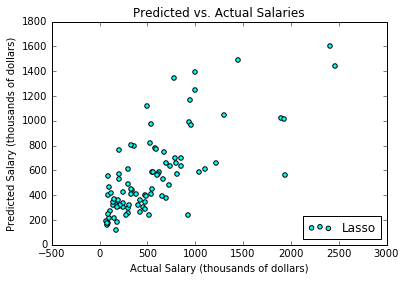

In [37]:
plt.scatter(y_test,lasso_model.predict(X_test), c = 'cyan',label='Lasso')
plt.legend(loc=4)
plt.title('Predicted vs. Actual Salaries')
plt.xlabel('Actual Salary (thousands of dollars)')
plt.ylabel('Predicted Salary (thousands of dollars)')
plt.show()

# Cross validation

In [38]:
from sklearn.linear_model import LassoLarsCV

In [39]:
lasso_model_cv = LassoLarsCV(cv = 10, precompute=False, fit_intercept=True, normalize=True).fit(X_train, y_train)

/home/niall/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=5.463e-01, previous alpha=7.792e-02, with an active set of 18 regressors.
  ConvergenceWarning)


Print coefficients for the best fit model

In [40]:
pd.DataFrame(zip(features_df.columns, lasso_model_cv.coef_))

,0,1
0,AtBat,0.000000
1,Hits,1.422570
2,HmRun,2.755447
3,Runs,1.040784
4,RBI,0.000000
5,Walks,0.694122
6,Years,0.000000
7,CAtBat,0.000000
8,CHits,0.000000
9,CHmRun,0.000000


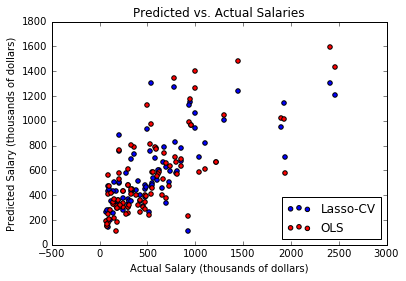

In [41]:
plt.scatter(y_test, lasso_model_cv.predict(X_test), c = 'blue', label='Lasso-CV')
plt.scatter(y_test, overfit_model.predict(X_test), c = 'red', label='OLS')
plt.legend(loc=4)
plt.title('Predicted vs. Actual Salaries')
plt.xlabel('Actual Salary (thousands of dollars)')
plt.ylabel('Predicted Salary (thousands of dollars)')
plt.show()

In [42]:
log_lambdascv = np.log10(lasso_model_cv.alphas_)

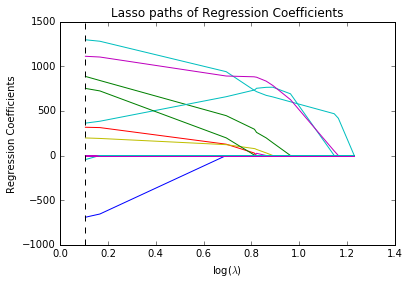

In [43]:
ax = plt.gca()
plt.plot(log_lambdascv, lasso_model_cv.coef_path_.T)
plt.axvline(np.log10(lasso_model_cv.alpha_), linestyle = '--', color = 'k', label = 'Lambda CV')
plt.ylabel('Regression Coefficients')
plt.xlabel('log($\lambda$)')
plt.title('Lasso paths of Regression Coefficients')
plt.show()